In [2]:
import os
import time
import shutil
import pathlib
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [3]:
# Split data into train, validation, and test sets
def split_data(data_dir):
    class_names = ['tomato_leaf', 'other_leaf', 'undifined']
    data = []
    labels = []
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        for file in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file)
            data.append(file_path)
            labels.append(class_name)  # use class_name instead of integer label

    df = pd.DataFrame({'filepaths': data, 'labels': labels})
    train_df, test_df = train_test_split(df, train_size=0.8, stratify=labels, random_state=123)
    valid_df, test_df = train_test_split(test_df, train_size=0.5, stratify=test_df['labels'], random_state=123)
    return train_df, valid_df, test_df



In [4]:
# Create image data generators
def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (256, 256)
    channels = 3
    color = 'rgb'

    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(
        preprocessing_function=scalar,
        horizontal_flip=True,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        shear_range=0.1,
        fill_mode='nearest'
    )
    ts_gen = ImageDataGenerator(preprocessing_function=scalar)

    train_gen = tr_gen.flow_from_dataframe(
        train_df, x_col='filepaths', y_col='labels',
        target_size=img_size, class_mode='categorical',
        color_mode=color, shuffle=True, batch_size=batch_size
    )
    valid_gen = ts_gen.flow_from_dataframe(
        valid_df, x_col='filepaths', y_col='labels',
        target_size=img_size, class_mode='categorical',
        color_mode=color, shuffle=True, batch_size=batch_size
    )
    test_gen = ts_gen.flow_from_dataframe(
        test_df, x_col='filepaths', y_col='labels',
        target_size=img_size, class_mode='categorical',
        color_mode=color, shuffle=False, batch_size=batch_size
    )
    return train_gen, valid_gen, test_gen

In [5]:
# Display images from generator
def show_images(gen):
    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    images, labels = next(gen)
    length = len(labels)
    sample = min(length, 25)

    plt.figure(figsize=(20, 20))
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()


In [6]:
# Define MyCallback class
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience
        self.stop_patience = stop_patience
        self.threshold = threshold
        self.factor = factor
        self.batches = batches
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch

        self.count = 0
        self.stop_count = 0
        self.best_epoch = 1
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))
        self.highest_tracc = 0.0
        self.lowest_vloss = np.inf
        self.best_weights = self.model.get_weights()
        self.initial_weights = self.model.get_weights()

    def on_train_begin(self, logs=None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds'
        print(msg)
        self.model.set_weights(self.best_weights)

    def on_train_batch_end(self, batch, logs=None):
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='')

    def on_epoch_begin(self, epoch, logs=None):
        self.ep_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        current_lr = lr
        acc = logs.get('accuracy')
        v_acc = logs.get('val_accuracy')
        loss = logs.get('loss')
        v_loss = logs.get('val_loss')

        if acc < self.threshold:
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc) * 100 / self.highest_tracc

            if acc > self.highest_tracc:
                self.highest_tracc = acc
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1

            else:
                if self.count >= self.patience - 1:
                    lr = lr * self.factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)
                    self.count = 0
                    self.stop_count += 1
                    self.count = 0
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count += 1

        else:
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (self.lowest_vloss - v_loss) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss:
                self.lowest_vloss = v_loss
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
                self.best_epoch = epoch + 1

            else:
                if self.count >= self.patience - 1:
                    lr = lr * self.factor
                    self.stop_count += 1
                    self.count = 0
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)
                else:
                    self.count += 1

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1:
            msg = f'training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f'training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)

                        except Exception:
                            print('Invalid')

In [7]:

# Plot training history
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()



In [8]:

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')


Found 16992 validated image filenames belonging to 3 classes.
Found 2124 validated image filenames belonging to 3 classes.
Found 2124 validated image filenames belonging to 3 classes.


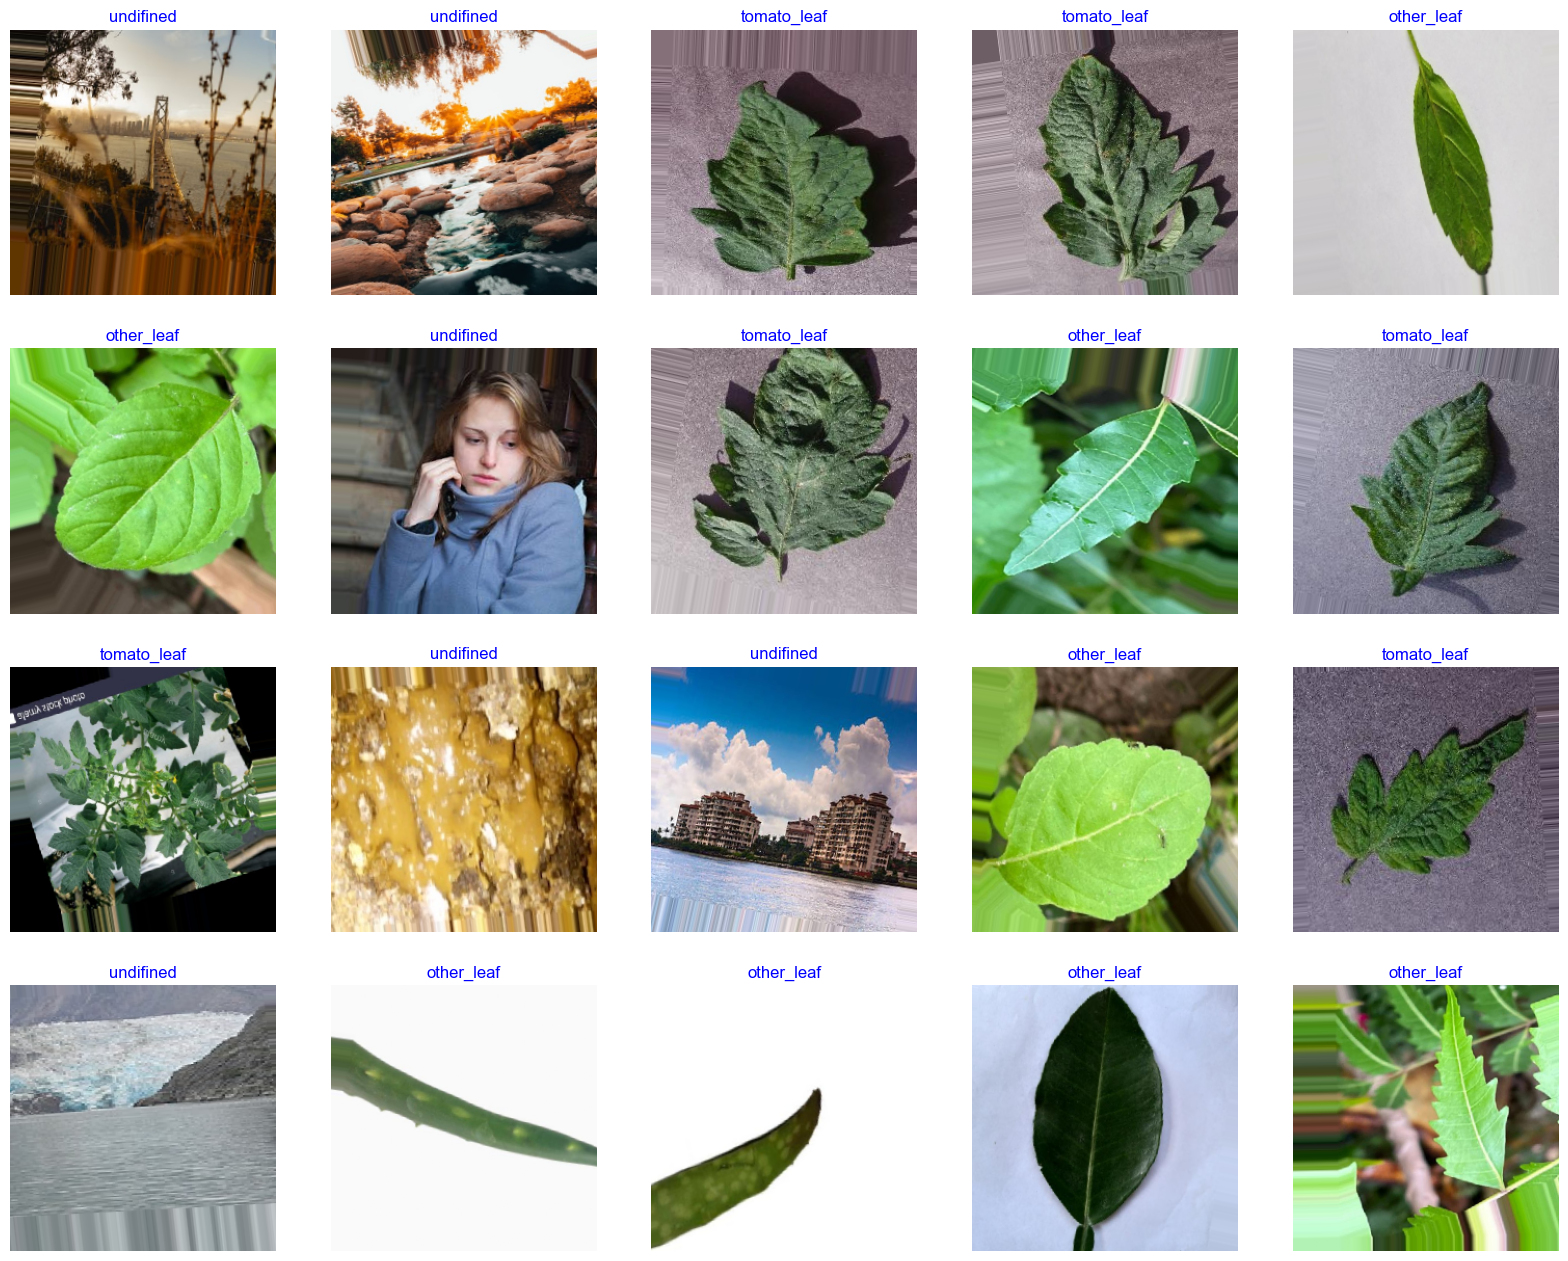

In [9]:

# Start reading dataset
data_dir = 'E:/KULIAHAHAHAH/semester 5 bismillah/Studi Independet Bersertifikat (Bangkit)/project/code/Classification Leaf/Classisfication Daun'
train_df, valid_df, test_df = split_data(data_dir)
batch_size = 20
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)
show_images(train_gen)


In [10]:
# Create Model Structure
img_size = (256, 256)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.efficientnet.EfficientNetB3(
    include_top= False, 
    weights= "imagenet", 
    input_shape= img_shape, 
    pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(512, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006), bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.5, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 11,578,162
Trainable params: 11,487,787
Non-trainable params: 90,375
_______________________________________

In [11]:
epochs = 10
patience = 3
stop_patience = 5
threshold = 0.9
factor = 0.5
ask_epoch = 5
batches = int(np.ceil(len(train_gen.labels) / batch_size))
callbacks = [MyCallback(model=model, patience=patience, stop_patience=stop_patience, threshold=threshold, factor=factor, batches=batches, epochs=epochs, ask_epoch=ask_epoch)]


In [12]:
history = model.fit(train_gen, epochs=epochs, verbose=0, callbacks=callbacks, validation_data=valid_gen)

Do you want model asks you to halt the training [y/n] ?
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /10     3.888   97.452   0.79872  99.623   0.00100  0.00100  val_loss     0.00   7858.21 
 2 /10     0.400   99.288   0.18960  99.859   0.00100  0.00100  val_loss    76.26   8978.93 
 3 /10     0.166   99.500   0.11087  99.953   0.00100  0.00100  val_loss    41.52   8790.84 
 4 /10     0.116   99.841   0.08769  99.906   0.00100  0.00100  val_loss    20.91   7898.10 
 5 /10     0.100   99.794   0.07873  99.953   0.00100  0.00100  val_loss    10.22   7703.66 
enter H to halt training or an integer for number of epochs to run then ask again
training has been halted at epoch 5 due to user input
training elapsed time was 12.0 hours,  2.0 minutes, 45.89 seconds


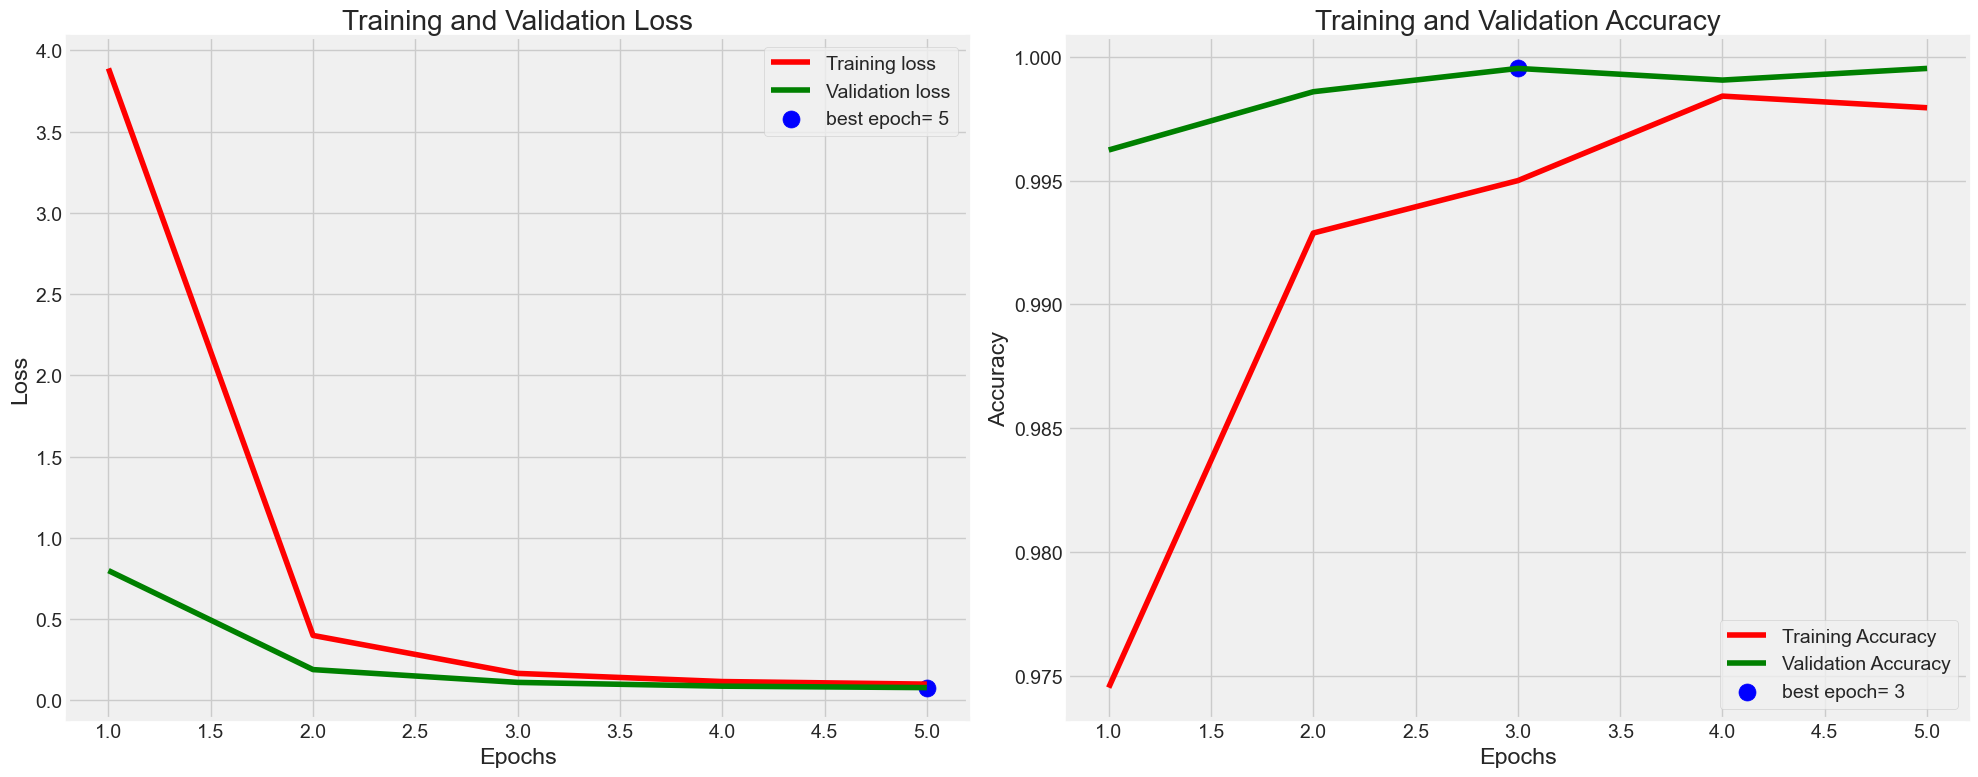

In [13]:
plot_training(history)

In [14]:
train_score = model.evaluate(train_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(test_gen, verbose=1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

107/107 [==============================] - 253s 2s/step - loss: 0.0771 - accuracy: 0.9995
Train Loss:  0.07563569396734238
Train Accuracy:  0.9998234510421753
--------------------
Validation Loss:  0.07872668653726578
Validation Accuracy:  0.9995291829109192
--------------------
Test Loss:  0.07713880389928818
Test Accuracy:  0.9995291829109192


In [15]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)


107/107 [==============================] - 248s 2s/step
[0 2 2 ... 0 2 0]


Confusion Matrix, Without Normalization
[[703   0   0]
 [  0 714   1]
 [  0   0 706]]
              precision    recall  f1-score   support

  other_leaf       1.00      1.00      1.00       703
 tomato_leaf       1.00      1.00      1.00       715
   undifined       1.00      1.00      1.00       706

    accuracy                           1.00      2124
   macro avg       1.00      1.00      1.00      2124
weighted avg       1.00      1.00      1.00      2124



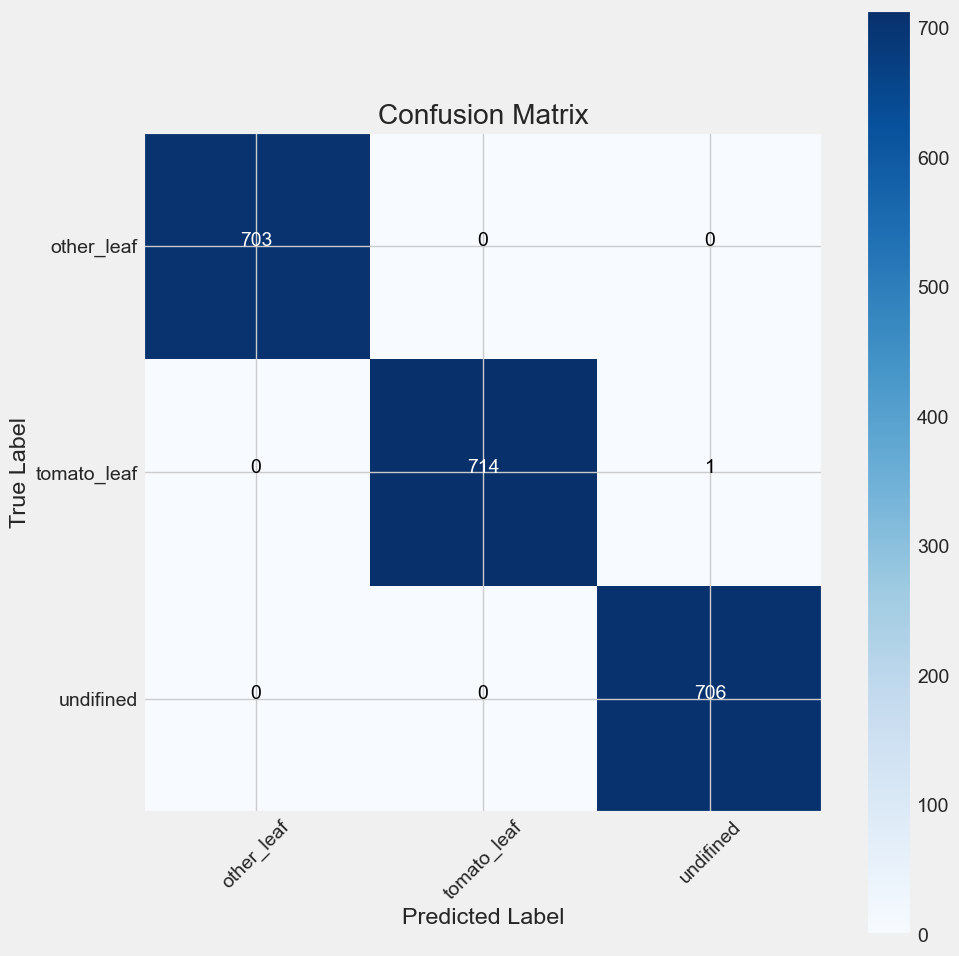

In [16]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm, classes, title='Confusion Matrix')
print(classification_report(test_gen.classes, y_pred, target_names=classes))

In [17]:
model_name = model.input_names[0][:-6]
subject = 'Classification_daun'
acc = test_score[1] * 100
save_path = ''

# Save model
save_id = f'{model_name}-{subject}-{"%.2f" % round(acc, 2)}.h5'
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = f'{model_name}-{subject}-weights.h5'
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

model was saved as efficientnetb3-Classification_daun-99.95.h5
weights were saved as efficientnetb3-Classification_daun-weights.h5


In [18]:
class_dict = train_gen.class_indices
img_size = train_gen.image_shape
height = [img_size[0]] * len(class_dict)
width = [img_size[1]] * len(class_dict)

Index_series = pd.Series(list(class_dict.values()), name='class_index')
Class_series = pd.Series(list(class_dict.keys()), name='class')
Height_series = pd.Series(height, name='height')
Width_series = pd.Series(width, name='width')
class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis=1)
csv_name = f'{subject}-class_dict.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index=False)
print(f'class csv file was saved as {csv_save_loc}')

class csv file was saved as Classification_daun-class_dict.csv
